In [1]:
import pandas as pd
import numpy as np

X_train = pd.read_csv('../../data/cve_2018-2020_X_train.csv')
y_train = pd.read_csv('../../data/cve_2018-2020_y_train.csv')

X_test = pd.read_csv('../../data/cve_2018-2020_X_test.csv')
y_test = pd.read_csv('../../data/cve_2018-2020_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

print(y_train['cvssV3_privilegesRequired'].value_counts(dropna=False) / y_train.shape[0])
print(y_test['cvssV3_privilegesRequired'].value_counts(dropna=False) / y_test.shape[0])
print(X_train.info())
print(y_train.info())

(22963, 2)
(22963, 2)
(22963, 16)
(22963, 16)
NONE    0.641423
LOW     0.282759
HIGH    0.075818
Name: cvssV3_privilegesRequired, dtype: float64
NONE    0.639943
LOW     0.282498
HIGH    0.077560
Name: cvssV3_privilegesRequired, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CVE_ID       22963 non-null  object
 1   Description  22963 non-null  object
dtypes: object(2)
memory usage: 358.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22963 entries, 0 to 22962
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   cvssV3_vectorString           22963 non-null  object 
 1   cvssV3_attackVector           22963 non-null  object 
 2   cvssV3_attackComplexity       22963 non-null  object 
 3   cvssV3_privilegesRequired   

**Training Hugging Face Bert-Small model to classify CVE vulnerability descriptions according to "privileges required" to exploit them**

**Privileges required**: This metric describes the level of privileges an attacker must possess before successfully exploiting the vulnerability. The Base Score is greatest if no privileges are required.

In [2]:
label_column_name = "cvssV3_privilegesRequired"
train_labels = y_train.loc[:, label_column_name]
test_labels = y_test.loc[:, label_column_name]


from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
print(le.classes_)

NUM_CLASSES = len(le.classes_)
print(NUM_CLASSES)

encoded_train_labels = le.transform(train_labels)
encoded_test_labels = le.transform(test_labels)

print(train_labels[:10], encoded_train_labels[:10])
print(len(X_train), len(train_labels), len(X_test), len(test_labels))

['HIGH' 'LOW' 'NONE']
3
0    NONE
1    NONE
2    NONE
3    NONE
4    NONE
5    NONE
6     LOW
7    NONE
8    NONE
9     LOW
Name: cvssV3_privilegesRequired, dtype: object [2 2 2 2 2 2 1 2 2 1]
22963 22963 22963 22963


In [3]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained('prajjwal1/bert-small')

In [4]:
train_encodings = tokenizer(X_train.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(X_test.loc[:,"Description"].tolist(), truncation=True, padding=True, max_length=128)

In [5]:
import torch

class CVEDataset(torch.utils.data.Dataset):
    def __init__(self, X, encodings, labels, encoded_labels):
        self.cve_id = X.loc[:,"CVE_ID"].tolist()
        self.texts = X.loc[:,"Description"].tolist()
        self.encodings = encodings
        self.labels = labels.tolist()
        self.encoded_labels = encoded_labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['text_labels'] = self.labels[idx]
        item['encoded_labels'] = torch.tensor(self.encoded_labels[idx])
        item['CVE_ID'] = self.cve_id[idx]
        item['vulnerability_description'] = self.texts[idx]
        
        return item

    def __len__(self):
        return len(self.labels)


In [6]:
train_dataset = CVEDataset(X_train, train_encodings, train_labels, encoded_train_labels)
test_dataset = CVEDataset(X_test, test_encodings, test_labels, encoded_test_labels)

In [7]:
train_dataset[0]

{'input_ids': tensor([  101,  1037, 18130,  1999, 26408, 16380, 17083,  8080,  1006, 17083,
          8202,  1007,  4007,  2005, 26408, 16771, 23944,  2692,  2186, 15924,
          2071,  3499,  2019, 14477, 14317,  4765, 17872,  1010,  2334, 17346,
          2000, 11826, 26408,  5851,  9573, 27354, 14148,  1998,  7170,  1037,
         20419,  4007,  3746,  2006,  2019,  5360,  5080,  1012,  1996, 18130,
          2003,  2349,  2000,  1996,  3739,  1997,  1037,  5023,  3094,  1999,
          1996,  5360,  4007,  1012,  2019, 17346,  2071, 18077,  2023, 18130,
          2011,  7176,  2000,  2019,  5360,  5080,  3081,  1996, 10122,  1010,
          6932,  1996,  5080,  2046, 17083,  8202,  5549,  1010,  1998,  3015,
          1037, 24391,  5418,  2000,  1037,  3563,  3638,  4769,  2006,  1996,
          5080,  1012,  1037,  3144, 18077,  2071,  3499,  1996, 17346,  2000,
         11826,  8085, 27354, 14148,  2011, 26408,  5851,  9573,  2974,  1998,
          7170,  1037, 20419,  4007,  3

In [8]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-small', num_labels=NUM_CLASSES)
model

Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [9]:
for param in model.base_model.parameters():
    param.requires_grad = False
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

classifier.weight tensor([[-0.0160, -0.0008, -0.0278,  ...,  0.0153,  0.0140, -0.0019],
        [ 0.0175, -0.0068,  0.0123,  ..., -0.0025, -0.0003,  0.0003],
        [-0.0231, -0.0301, -0.0032,  ..., -0.0384,  0.0252,  0.0052]])
classifier.bias tensor([0., 0., 0.])


In [10]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.8334724399155038, Training Accuracy = 0.63545703958542
Epoch: 1, Training Loss: 0.8060802256677363, Training Accuracy = 0.6436876714714976
Epoch: 2, Training Loss: 0.792352342872427, Training Accuracy = 0.6473892784043896


In [11]:
for param in model.base_model.parameters():
    param.requires_grad = True
    
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

bert.embeddings.word_embeddings.weight tensor([[ 0.0770, -0.1024,  0.0109,  ...,  0.0265,  0.0527, -0.0099],
        [-0.0062, -0.0448,  0.0068,  ...,  0.0460,  0.0177, -0.0487],
        [-0.0014, -0.0184,  0.0207,  ...,  0.0936,  0.0561, -0.0690],
        ...,
        [-0.0539, -0.0298,  0.0711,  ...,  0.0057,  0.0172, -0.0437],
        [ 0.0446, -0.0571,  0.0028,  ..., -0.0138,  0.0534, -0.0741],
        [ 0.0798,  0.0307, -0.0254,  ...,  0.0389,  0.0417, -0.0208]])
bert.embeddings.position_embeddings.weight tensor([[-2.2368e-03, -1.6215e-02, -5.7656e-03,  ..., -8.1258e-02,
         -1.8137e-02,  1.0507e-03],
        [-1.4434e-02, -9.5276e-03, -3.3733e-04,  ...,  2.2632e-02,
         -2.4823e-02, -2.0542e-02],
        [-1.3487e-02, -6.8095e-05,  7.1685e-03,  ...,  4.7153e-03,
         -1.9992e-03,  6.1711e-03],
        ...,
        [ 2.4908e-02, -1.1784e-03, -9.2854e-03,  ...,  1.1964e-03,
         -1.9798e-02,  4.2636e-03],
        [ 2.8236e-02, -1.1161e-02,  1.2986e-02,  ..., -1.31

In [12]:
from torch.utils.data import DataLoader
from transformers import AdamW
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)
model.train()

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

optim = AdamW(model.parameters(), lr=5e-5)

training_loss_batch = []
training_loss_epoch = []

for epoch in range(3):
    model.train()
    training_loss = 0
    num_correct = 0 
    num_examples = 0
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['encoded_labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optim.step()
        training_loss_batch.append(loss.data.item())
        training_loss += loss.data.item() * input_ids.size(0)
        correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
        num_correct += torch.sum(correct).item()
        num_examples += correct.shape[0]
    training_loss /= len(train_loader.dataset)
    training_loss_epoch.append(training_loss)
    
    print('Epoch: {}, Training Loss: {}, Training Accuracy = {}'.format(epoch, training_loss, num_correct / num_examples))

  

Epoch: 0, Training Loss: 0.5203286175039885, Training Accuracy = 0.7981100030483822
Epoch: 1, Training Loss: 0.39072918463359646, Training Accuracy = 0.8534163654574751
Epoch: 2, Training Loss: 0.30798670574107717, Training Accuracy = 0.8854679266646344


In [13]:
#model.save_pretrained('./bert-small-vulnerability_privileges_required-classification')

In [14]:
test_loader = DataLoader(test_dataset, batch_size=16)

model.eval()
num_correct = 0 
num_examples = 0
test_loss = 0
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    correct = torch.eq(torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1], labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))

Test Loss: 0.4408513136639265, Test Accuracy = 0.8378696163393284


**Save the predictions obtained on the test set for further analysis**

In [15]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_privileges_required-classification')
model.eval()

test_loader = DataLoader(test_dataset, batch_size=16)


num_correct = 0 
num_examples = 0
test_loss = 0
predicted_labels_list = []
predicted_labels_score_list = []
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['encoded_labels'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
    loss = outputs[0]
    test_loss += loss.data.item() * input_ids.size(0)
    predicted_labels = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1]
    predicted_labels_list.extend(predicted_labels.tolist())
    predicted_labels_score = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0]
    predicted_labels_score_list.extend(predicted_labels_score.tolist())
    correct = torch.eq(predicted_labels, labels)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
test_loss /= len(test_loader.dataset)

        
print('Test Loss: {}, Test Accuracy = {}'.format(test_loss, num_correct / num_examples))
print('predicted labels:', predicted_labels_list, 'scores:', predicted_labels_score_list)

Test Loss: 0.4408513136639265, Test Accuracy = 0.8378696163393284
predicted labels: [1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 1, 2, 2, 1, 1, 

In [16]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

y_true = test_dataset[:]['encoded_labels'].numpy()
y_pred = np.array(predicted_labels_list)

print("accuracy: ", accuracy_score(y_true, y_pred))
print("precision: ", precision_score(y_true, y_pred, average='weighted'))
print("recall: ", recall_score(y_true, y_pred, average='weighted'))
print("f1 score: ", f1_score(y_true, y_pred, average='weighted'))


print("confusion matrix: ")
print(confusion_matrix(y_true, y_pred))

accuracy:  0.8378696163393284
precision:  0.8392183014148944
recall:  0.8378696163393284
f1 score:  0.8377764197806634
confusion matrix: 
[[ 1094   417   270]
 [  178  5097  1212]
 [  198  1448 13049]]


In [17]:
class_label = list(le.classes_)
class_label
predicted_labels_char = [class_label[i] for i in predicted_labels_list]

print(len(predicted_labels_char))
print(len(predicted_labels_list))

22963
22963


(array([   56.,   213.,   630.,   842.,   910.,   973.,  1149.,  1527.,
         2676., 13987.]),
 array([0.337403  , 0.40349088, 0.46957877, 0.53566665, 0.60175453,
        0.66784242, 0.7339303 , 0.80001819, 0.86610607, 0.93219395,
        0.99828184]),
 <BarContainer object of 10 artists>)

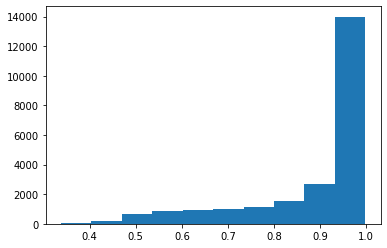

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(predicted_labels_score_list, bins=10)

In [19]:
from scipy import stats

print("percentile of 0.9: ", stats.percentileofscore(predicted_labels_score_list, 0.9))

percentile of 0.9:  32.29543178156164


In [20]:
file_name = 'privileges_required'

import pickle

with open(file_name + "_predicted_class_int.txt", "wb") as f1:
    pickle.dump(predicted_labels_list, f1)
    
with open(file_name + "_predicted_labels_char.txt", "wb") as f2:
    pickle.dump(predicted_labels_char, f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "wb") as f3:
    pickle.dump(predicted_labels_score_list, f3)
 

In [21]:
with open(file_name + "_predicted_class_int.txt", "rb") as f1:
    pred_class = pickle.load(f1)
    
with open(file_name + "_predicted_labels_char.txt", "rb") as f2:
    pred_label = pickle.load(f2)
    
with open(file_name + "_predicted_class_confidence_score.txt", "rb") as f3:
    pred_confidence_score = pickle.load(f3)
    
print(len(pred_class), len(pred_label), len(pred_confidence_score))
print(pred_class, pred_label, pred_confidence_score)

22963 22963 22963
[1, 2, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 0, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 2, 1, 2, 1, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 2, 0, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 1, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 1, 1, 0, 2, 1, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 2, 2, 1, 1, 

**Explaining classification results using gradient-based saliency**

In [8]:
import torch
from transformers import BertForSequenceClassification
from torch.utils.data import DataLoader
import torch.nn.functional as F

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('./bert-small-vulnerability_privileges_required-classification/')
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [9]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

test_batch = next(iter(test_loader))
test_batch['input_ids']
input_ids = test_batch['input_ids']
attention_mask = test_batch['attention_mask']
labels = test_batch['encoded_labels']



outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

print(outputs.loss)
print(outputs.logits)
print(torch.max(F.softmax(outputs.logits, dim=1), dim=1))
print(labels)

tensor(0.4999, grad_fn=<NllLossBackward>)
tensor([[-2.2046,  2.1337, -1.1807],
        [-1.7562,  2.6470, -2.0832],
        [-2.3833, -1.2626,  2.7002],
        [-2.9404,  1.6361, -0.3098],
        [-1.5163,  1.3247, -1.3618],
        [-2.4780,  0.7120,  0.8905],
        [-3.3442, -2.0271,  4.2279],
        [-3.4213, -0.0557,  1.8298],
        [-3.5906, -1.8380,  3.9142],
        [-1.2728, -0.5166,  1.2205],
        [-3.2275, -2.0057,  3.9998],
        [ 3.0225,  1.3627, -3.6322],
        [-3.3940, -1.5244,  3.4411],
        [-2.4810, -0.6659,  2.0437],
        [-2.6900, -1.0139,  2.4849],
        [ 0.4477,  2.2849, -2.8109]], grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([0.9529, 0.9794, 0.9754, 0.8672, 0.8877, 0.5345, 0.9976, 0.8643, 0.9963,
        0.7945, 0.9968, 0.8393, 0.9920, 0.9282, 0.9654, 0.8581],
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1]))
tensor([1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 1])


In [24]:
selected_idx = -5
input_ids[selected_idx].tolist()

[101,
 1037,
 18130,
 1999,
 1996,
 2334,
 2291,
 3447,
 6922,
 1997,
 10927,
 3148,
 15240,
 4807,
 3208,
 2064,
 3499,
 2019,
 14469,
 4383,
 1010,
 21598,
 5310,
 2006,
 1996,
 2334,
 2291,
 2000,
 5114,
 7117,
 14310,
 1012,
 5360,
 4617,
 2421,
 1020,
 1012,
 1017,
 1012,
 1060,
 1998,
 2035,
 1021,
 1012,
 1060,
 2544,
 3188,
 2000,
 1021,
 1012,
 1015,
 1012,
 1017,
 1012,
 1015,
 1012,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [25]:
#transform each input token into an one-hot encoded representation.

from torch.autograd import Variable

input_embedding = model.get_input_embeddings()
vocab_size = input_embedding.weight.shape[0]

input_ids_one_hot = torch.nn.functional.one_hot(input_ids[selected_idx], num_classes=vocab_size)
input_ids_one_hot = input_ids_one_hot.type(torch.float)
input_ids_one_hot = Variable(input_ids_one_hot, requires_grad=True) #to allow the computation of the gradients with respect to the input 
print(input_ids_one_hot.grad)

None


In [26]:
#Calculate the input embeddings manually and pass them to the model through the inputs_embeds argument
inputs_embeds = torch.matmul(input_ids_one_hot, input_embedding.weight)
embedding_dim = input_embedding.weight.shape[1]
inputs_embeds = torch.mul(inputs_embeds, torch.cat([attention_mask[selected_idx].unsqueeze(1)]*embedding_dim, dim=1))


outputs = model(inputs_embeds=inputs_embeds.unsqueeze(0), attention_mask=attention_mask[selected_idx].unsqueeze(0), labels=labels[selected_idx].unsqueeze(0))

print("loss:", outputs.loss)
print("logits:", outputs.logits)

predicted_label = torch.max(F.softmax(outputs.logits, dim=1), dim=1)[1].item()
print("predicted label (after softmax):", predicted_label)
print("score for predicted label (after softmax):", torch.max(F.softmax(outputs.logits, dim=1), dim=1)[0].item())
print("sample true label:", labels[selected_idx])

outputs.logits[0][predicted_label].backward() #compute the gradient of the logit (predicted, the one with the highest score)
print(input_ids_one_hot.grad)                  #with respect to the input

loss: tensor(0.1752, grad_fn=<NllLossBackward>)
logits: tensor([[ 3.0225,  1.3627, -3.6322]], grad_fn=<AddmmBackward>)
predicted label (after softmax): 0
score for predicted label (after softmax): 0.8393101692199707
sample true label: tensor(0)
tensor([[ 0.0202, -0.0264, -0.0612,  ..., -0.0489, -0.0764, -0.0380],
        [-0.0396, -0.0081, -0.0431,  ...,  0.0078, -0.0341, -0.0222],
        [ 0.2451,  0.2991,  0.2238,  ...,  0.1655,  0.2213,  0.1508],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [27]:
connectivity_tensor = torch.linalg.norm(input_ids_one_hot.grad, dim=1)
connectivity_tensor = connectivity_tensor/torch.max(connectivity_tensor)
connectivity_tensor

tensor([0.0939, 0.0655, 0.2622, 0.0695, 0.0510, 0.1703, 0.1234, 0.2572, 0.1187,
        0.0910, 0.0732, 0.3197, 0.2693, 0.6134, 0.2340, 0.2538, 0.4121, 0.1803,
        0.3972, 0.4505, 0.5676, 1.0000, 0.5623, 0.1806, 0.1010, 0.2894, 0.2255,
        0.1640, 0.1628, 0.1070, 0.3005, 0.1041, 0.1277, 0.0828, 0.1140, 0.0753,
        0.0292, 0.0447, 0.0322, 0.0628, 0.0415, 0.0527, 0.0836, 0.0437, 0.0735,
        0.0616, 0.0681, 0.0374, 0.0485, 0.0290, 0.0331, 0.0211, 0.0307, 0.0221,
        0.0240, 0.0279, 0.1051, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [28]:
indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
input_tokens = tokenizer.convert_ids_to_tokens(list(input_ids[selected_idx]))
top_3_indices_sorted = indices_sorted_by_connectivity[-3:].flip(dims=(0,))

print(input_tokens)
print("Most influential words by order:")
for position, score in zip(top_3_indices_sorted,
                                 connectivity_tensor[top_3_indices_sorted]):
    print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())

['[CLS]', 'a', 'vulnerability', 'in', 'the', 'local', 'system', 'administration', 'component', 'of', 'ava', '##ya', 'aura', 'communication', 'manager', 'can', 'allow', 'an', 'authentic', '##ated', ',', 'privileged', 'user', 'on', 'the', 'local', 'system', 'to', 'gain', 'root', 'privileges', '.', 'affected', 'versions', 'include', '6', '.', '3', '.', 'x', 'and', 'all', '7', '.', 'x', 'version', 'prior', 'to', '7', '.', '1', '.', '3', '.', '1', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]',

In [29]:
import re

def print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=3):
    #input_text_str: python string coreesponding to the raw textual input
    #input_tokens: python list corresponding to the tokenized representation of the input
    #connectivity_tensor: pytorch tensor containing the gradient norm of the gradient of the logit with respect to each input token
    #top_k: int representing the maximum number of top words to consider
    BOLD = '\033[1m'
    END = '\033[0m'
    
    output_str = input_text_str
    indices_sorted_by_connectivity = torch.argsort(connectivity_tensor)
    top_indices_sorted = indices_sorted_by_connectivity[-top_k:].flip(dims=(0,))
    
    print("Most influential words by order:")
    for position, score in zip(top_indices_sorted,
                                     connectivity_tensor[top_indices_sorted]):
        print(input_tokens[position.item()], "\tposition: ", position.item(), "\tconnectivity weight: ", score.item())
        
        if input_tokens[position.item()] in ['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']:
            continue
        
        #find the indices of every tokens containing the selected word (or token)
        indices_all_matches = [i for i, x in enumerate(input_tokens) if re.sub('^##', '', input_tokens[position.item()]) in x]
        #keep only the position intended by the model (when multiple occurences of the same word).
        #For example, if selected words occurs 3 times in the description, and the algorithms is mostly influenced by
        #second occurrence, then return 1, 3rd occurence return 2, etc
        position_of_the_intended_match = [i for i, x in enumerate(indices_all_matches) if x == position.item()]
        
        test_sub = re.escape(re.sub('^##', '', input_tokens[position.item()]))
        res = [i.start() for i in re.finditer(test_sub, output_str, re.IGNORECASE)]
        idx = position_of_the_intended_match[0]
        output_str = output_str[:res[idx]] + BOLD + output_str[res[idx]:res[idx]+len(test_sub)] + END + output_str[res[idx]+len(test_sub):]
    print(output_str)
    return output_str

In [30]:
input_text_str = test_batch['vulnerability_description'][selected_idx]
print_texts_with_top_influential_words_in_bold(input_text_str, input_tokens, connectivity_tensor, top_k=5)

Most influential words by order:
privileged 	position:  21 	connectivity weight:  1.0
communication 	position:  13 	connectivity weight:  0.6134433746337891
, 	position:  20 	connectivity weight:  0.5676482915878296
user 	position:  22 	connectivity weight:  0.5622841715812683
##ated 	position:  19 	connectivity weight:  0.4505491256713867
A vulnerability in the local system administration component of Avaya Aura Communication Manager can allow an authenticated, privileged user on the local system to gain root privileges. Affected versions include 6.3.x and all 7.x version prior to 7.1.3.1.


'A vulnerability in the local system administration component of Avaya Aura \x1bCommunication\x1b Manager can allow an authentic\x1bated\x1b\x1b,\x1b \x1bprivileged\x1b \x1buser\x1b on the local system to gain root privileges. Affected versions include 6.3.x and all 7.x version prior to 7.1.3.1.'

In [31]:
test_batch['CVE_ID'][selected_idx]

'CVE-2018-15611'